In [29]:
from scipy import stats
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# os.getcwd()

# https://www.kaggle.com/code/somertonman/a-b-testing-bootstrap-statistics-step-by-step
# https://www.kaggle.com/code/moghazy/easy-guide-a-b-testing-bootstrapping/notebook

In [22]:
df = pd.read_csv('marketing_AB.csv')

if "Unnamed: 0" in df.columns:
   
    df = df.drop(["Unnamed: 0"], axis =1)

df.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)

df.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [23]:
df = df.drop(['total_ads'], axis =1)
df = df.drop(['most_ads_day'], axis =1)
df = df.drop(['most_ads_hour'], axis =1)
df = df.drop(['user_id'], axis = 1)
df.head()

,test_group,converted
0,ad,False
1,ad,False
2,ad,False
3,ad,False
4,ad,False


In [24]:
df['test_group'] = df['test_group'].replace(['ad'], 'treatment')
df['test_group'] = df['test_group'].replace(['psa'], 'control')

df['converted'] = df['converted'].replace([True], 1)
df['converted'] = df['converted'].replace([False], 0)

df.head()

,test_group,converted
0,treatment,0
1,treatment,0
2,treatment,0
3,treatment,0
4,treatment,0


In [25]:
# make pivot table
ab_summary = df.pivot_table(values='converted', index='test_group', aggfunc=np.sum)

# add additional columns to the pivot table
ab_summary['total'] = df.pivot_table(values='converted', index='test_group', aggfunc=lambda x: len(x))
ab_summary['rate'] = df.pivot_table(values='converted', index='test_group')

In [10]:
ab_summary

,converted,total,rate
test_group,,,
control,420,23524,0.017854
treatment,14423,564577,0.025547


In [28]:
# Bootstrap

# Calculate the observed difference and the conversion for the groups
#    Args:
#       df: input DataFrame object
#    Returns:
#        ob_dif: difference between group conversion rates
#        data_control_conv: Conversion Rate for the control
#        data_exp_conv: Conversion Rate for the experimental

def get_obbs_diff(df):

    # Split into control & experimental groups
    data_control = df[df["test_group"] == "control"]
    data_exp = df[df["test_group"] == "treatment"]
    
    # Calculate the mean conversion rate for each group
    data_control_conv = data_control.converted.mean()
    data_exp_conv = data_exp.converted.mean()

    # Calculate the differnce in mean conversion rate between groups
    ob_dif = data_exp_conv - data_control_conv

    return ob_dif, data_control_conv, data_exp_conv

obs , _, _ = get_obbs_diff(df)


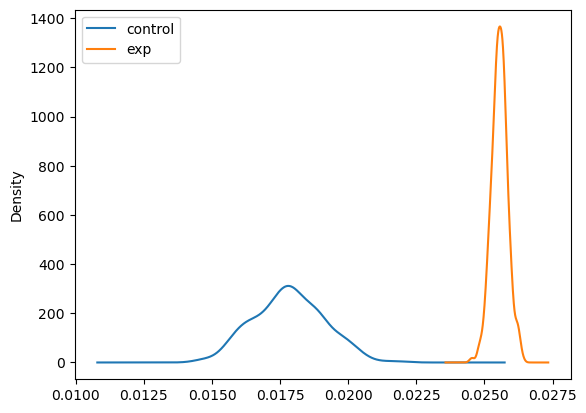

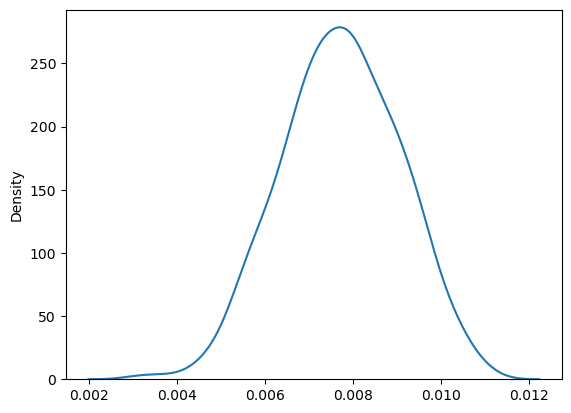

In [73]:
boot_mean = []; boot_mean_control = []; boot_mean_exp = []

# Bootstrap Sampling to get the test statestic distribution

for i in range(10000):
    boot_sample = df.sample(frac=1, replace=True) # for each run, take a random sample equivalent to 100% of the number of observations in the data set with replacement
    boot_diff, boot_mean_control_tmp, boot_mean_exp_tmp = get_obbs_diff(boot_sample)
    boot_mean.append(boot_diff)
    boot_mean_exp.append(boot_mean_exp_tmp)
    boot_mean_control.append(boot_mean_control_tmp)
    
# Now let's show the difference between the distributions on a plot
# the more seperated the graph the more we can predict that we might 
# accept the Alternative hypothesis if it is in the right direction
boot_gr = pd.DataFrame({"control": boot_mean_control, "exp": boot_mean_exp})
boot_gr.plot(kind='kde')
plt.show()

# We can also see the difference as a dist plot here
ax = sns.kdeplot(np.array(boot_mean))

In [74]:
prob = (np.array(boot_mean) > 0).mean()
prob

1.0

0.374

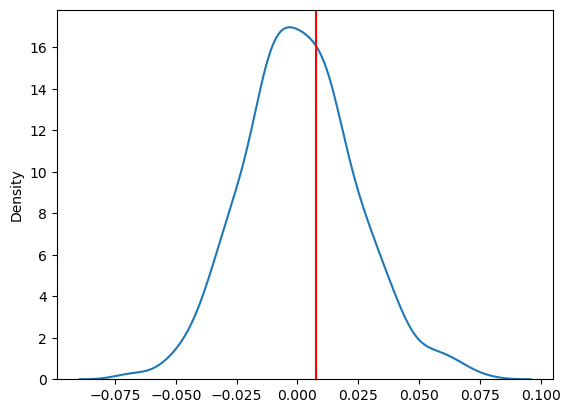

In [70]:
standard_dev = np.array(boot_mean).std()
h_ = np.random.normal(0, standard_dev, np.array(boot_mean).shape)
sns.kdeplot(h_)
plt.axvline(obs, color = "r")

p_val = (h_ > obs).mean()
p_val

In [62]:
boot_all = pd.DataFrame({"control": boot_mean_control, "exp": boot_mean_exp, 'diff' : boot_mean})
boot_all


,control,exp,diff
0,0.017481,0.025351,0.007871
1,0.017933,0.025434,0.007501
2,0.017402,0.025160,0.007758
3,0.015649,0.025384,0.009735
4,0.018693,0.025182,0.006489
...,...,...,...
95,0.017770,0.025462,0.007692
96,0.018371,0.025331,0.006960
97,0.016802,0.025322,0.008520
98,0.018117,0.025560,0.007442
